In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Reading dataset

In [4]:
from pathlib import Path
import os

In [5]:
data_path = Path("dataset_split")

In [6]:
train_dir = data_path / "train"
val_dir = data_path / "val"
test_dir = data_path / "test"

# Transforming of data

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [10]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform = train_transform,
    target_transform = None
)
val_data = datasets.ImageFolder(
    root=val_dir,
    transform = test_transform,
    target_transform = None
)
test_data = datasets.ImageFolder(
    root=test_dir,
    transform = test_transform,
    target_transform = None
)

In [11]:
#Get classes name 
class_names = train_data.classes
len(class_names)

26

In [12]:
# change classes to dic
class_dict = train_data.class_to_idx
class_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 4,
 'Corn_(maize)___Common_rust_': 5,
 'Corn_(maize)___Northern_Leaf_Blight': 6,
 'Corn_(maize)___healthy': 7,
 'Orange___Haunglongbing_(Citrus_greening)': 8,
 'Peach___Bacterial_spot': 9,
 'Peach___healthy': 10,
 'Pepper,_bell___Bacterial_spot': 11,
 'Pepper,_bell___healthy': 12,
 'Potato___Early_blight': 13,
 'Potato___Late_blight': 14,
 'Potato___healthy': 15,
 'Tomato___Bacterial_spot': 16,
 'Tomato___Early_blight': 17,
 'Tomato___Late_blight': 18,
 'Tomato___Leaf_Mold': 19,
 'Tomato___Septoria_leaf_spot': 20,
 'Tomato___Spider_mites Two-spotted_spider_mite': 21,
 'Tomato___Target_Spot': 22,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 23,
 'Tomato___Tomato_mosaic_virus': 24,
 'Tomato___healthy': 25}

In [13]:
len(train_data),len(val_data),len(test_data)

(26569, 7587, 3818)

# Turn loaded data to Dataloaders

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
BATCH_SIZE = 16
NUM_WORKERS = 0
targets = train_data.targets 

class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size= BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle=False,
    pin_memory=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size= BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle=False
)

# Architecture

In [ ]:
import torch
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self, input_channels=3, num_classes=26):
        super(VGG19, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.MaxPool2d(2, 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.MaxPool2d(2, 2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.MaxPool2d(2, 2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.MaxPool2d(2, 2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.MaxPool2d(2, 2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(0.3),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)   
        x = self.classifier(x)
        return x


# Training

In [16]:
def train_step(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    optimizer:torch.optim.Optimizer,
    device=device
):
    model.train()
    train_loss,train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc +=(y_pred_class == y).sum().item() / len(y)
    train_acc = train_acc / len(dataloader)
    train_loss = train_loss / len(dataloader)
    return train_loss,train_acc

In [17]:
def val_step(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device=device
):
    model.eval()
    val_loss,val_acc= 0,0
    with torch.inference_mode():
         for batch,(X,y) in enumerate(dataloader):
             X,y = X.to(device), y.to(device)
             val_pred_logits = model(X)
             loss = loss_fn(val_pred_logits,y)
             val_loss += loss.item()
             val_pred_labels = val_pred_logits.argmax(dim=1)
             val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)
    val_loss = val_loss/len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss,val_acc
             

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [19]:
from tqdm.auto import tqdm
def train (
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device = device
):
    print("Model is on:", next(model.parameters()).device)
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)
    results = {
        "train_loss":[],
        "train_acc":[],
         "val_loss":[],
         "val_acc":[],
    }
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc = train_step(
            model = model,
            dataloader= train_dataloader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device
        )
        val_loss,val_acc = val_step(
            model = model,
            dataloader= val_dataloader,
            loss_fn = loss_fn,
            device = device
        )
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        # --- Early Stopping ---
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered! Training stopped early.")
            break
    return results

In [4]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 15
model = VGG19().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 1e-4
)

In [21]:
from timeit import default_timer as timer
start_time = timer()
model_results = train(
    model = model, 
    train_dataloader = train_dataloader,
    val_dataloader = val_dataloader ,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = NUM_EPOCHS
)
end_time = timer()
print(f"Total training time: {end_time-start_time:3f} sec")

Model is on: cuda:0


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.6708 | Train Acc: 0.4836 | Val Loss: 0.9103 | Val Acc: 0.6975
Epoch: 1 | Train Loss: 0.8256 | Train Acc: 0.7335 | Val Loss: 0.5495 | Val Acc: 0.8148684210526316
Epoch: 2 | Train Loss: 0.5603 | Train Acc: 0.8192 | Val Loss: 0.3712 | Val Acc: 0.8778947368421053
Epoch: 3 | Train Loss: 0.4374 | Train Acc: 0.8573 | Val Loss: 0.2560 | Val Acc: 0.9097368421052632
Epoch: 4 | Train Loss: 0.3641 | Train Acc: 0.8830 | Val Loss: 0.2245 | Val Acc: 0.9263157894736842
Epoch: 5 | Train Loss: 0.3122 | Train Acc: 0.8991 | Val Loss: 0.2670 | Val Acc: 0.9111842105263158
EarlyStopping counter: 1/10
Epoch: 6 | Train Loss: 0.2663 | Train Acc: 0.9133 | Val Loss: 0.1718 | Val Acc: 0.9422368421052632
Epoch: 7 | Train Loss: 0.2496 | Train Acc: 0.9180 | Val Loss: 0.1798 | Val Acc: 0.9411842105263157
EarlyStopping counter: 1/10
Epoch: 8 | Train Loss: 0.2232 | Train Acc: 0.9286 | Val Loss: 0.1736 | Val Acc: 0.9427631578947369
EarlyStopping counter: 2/10
Epoch: 9 | Train Loss: 0.2061 | Train

In [22]:
torch.save(model.state_dict(), "vgg19_last.pth")
print("Model saved as vgg19_last.pth")

Model saved as vgg19_last.pth


In [23]:
import pandas as pd

df = pd.DataFrame({
    "train_loss": model_results["train_loss"],
    "val_loss": model_results["val_loss"],
    "train_acc": model_results["train_acc"],
    "val_acc": model_results["val_acc"]
})

df.to_csv("training_metrics_new.csv", index=False)
print("Saved training metrics to training_metrics.csv")

Saved training metrics to training_metrics.csv


# Testing

In [24]:
def test_step(model, dataloader, loss_fn, device="cpu"):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    accuracy = correct / total
    test_loss = test_loss / len(dataloader)
    return test_loss, accuracy

loss_fn = nn.CrossEntropyLoss()

test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


Test Loss: 0.1139 | Test Accuracy: 0.9646


In [ ]:
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image

def predict_random_images(test_dataset, model, class_names, num_images=5, device="cuda"):
    model.eval()

    indices = random.sample(range(len(test_dataset)), num_images)

    plt.figure(figsize=(4 * num_images, 4))

    for i, idx in enumerate(indices):
        img_path, true_label = test_dataset.imgs[idx]

        img = Image.open(img_path).convert("RGB")

        img_tensor = test_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)

        pred_label = class_names[predicted.item()]
        true_label_name = class_names[true_label]

        ax = plt.subplot(1, num_images, i + 1)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

        ax.text(
            0.5, -0.12,
            f"True: {true_label_name}\nPred: {pred_label}",
            fontsize=10,
            ha="center",
            va="top",
            transform=ax.transAxes
        )

    plt.tight_layout()
    plt.show()


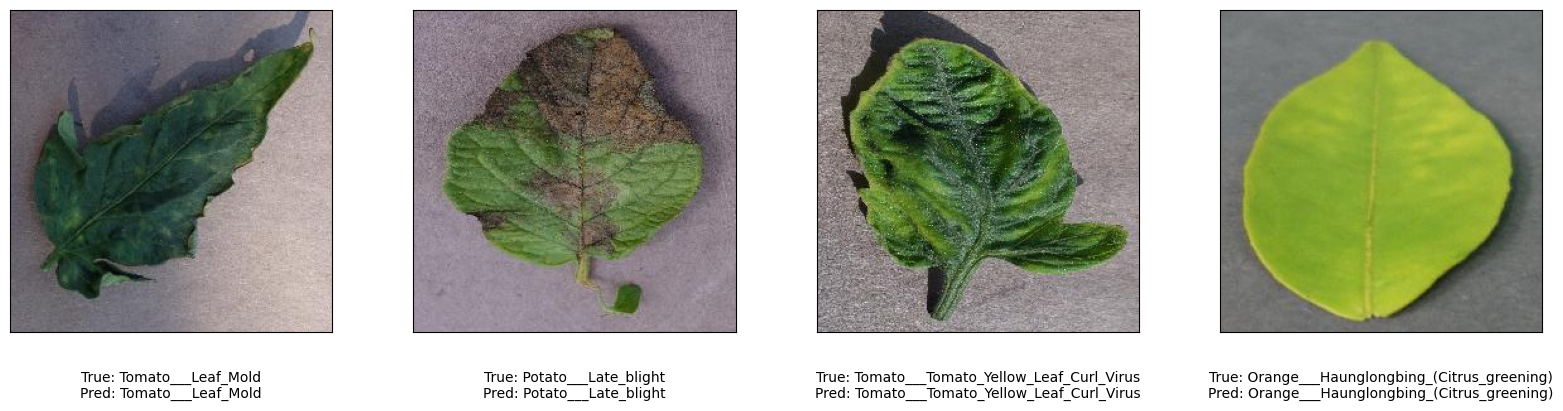

In [26]:
predict_random_images(test_data, model, test_data.classes, num_images=4)


# Evaluation metrics

In [27]:
import torch

model = VGG19(num_classes=26)   
model.load_state_dict(torch.load("vgg19_last.pth", map_location=device))
model = model.to(device)
model.eval()


VGG19(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [28]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, class_names, device="cuda"):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [29]:
y_true, y_pred, y_prob = evaluate_model(model, test_dataloader, class_names)

print("Accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Accuracy: 0.964641173389209

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.97      0.98        63
                                 Apple___Black_rot       0.98      1.00      0.99        63
                          Apple___Cedar_apple_rust       1.00      0.96      0.98        28
                                   Apple___healthy       0.98      1.00      0.99       165
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.80      1.00      0.89        52
                       Corn_(maize)___Common_rust_       1.00      0.98      0.99       120
               Corn_(maize)___Northern_Leaf_Blight       0.99      0.89      0.94        99
                            Corn_(maize)___healthy       0.97      1.00      0.99       117
          Orange___Haunglongbing_(Citrus_greening)       1.00      0.99      1.00       552
                           

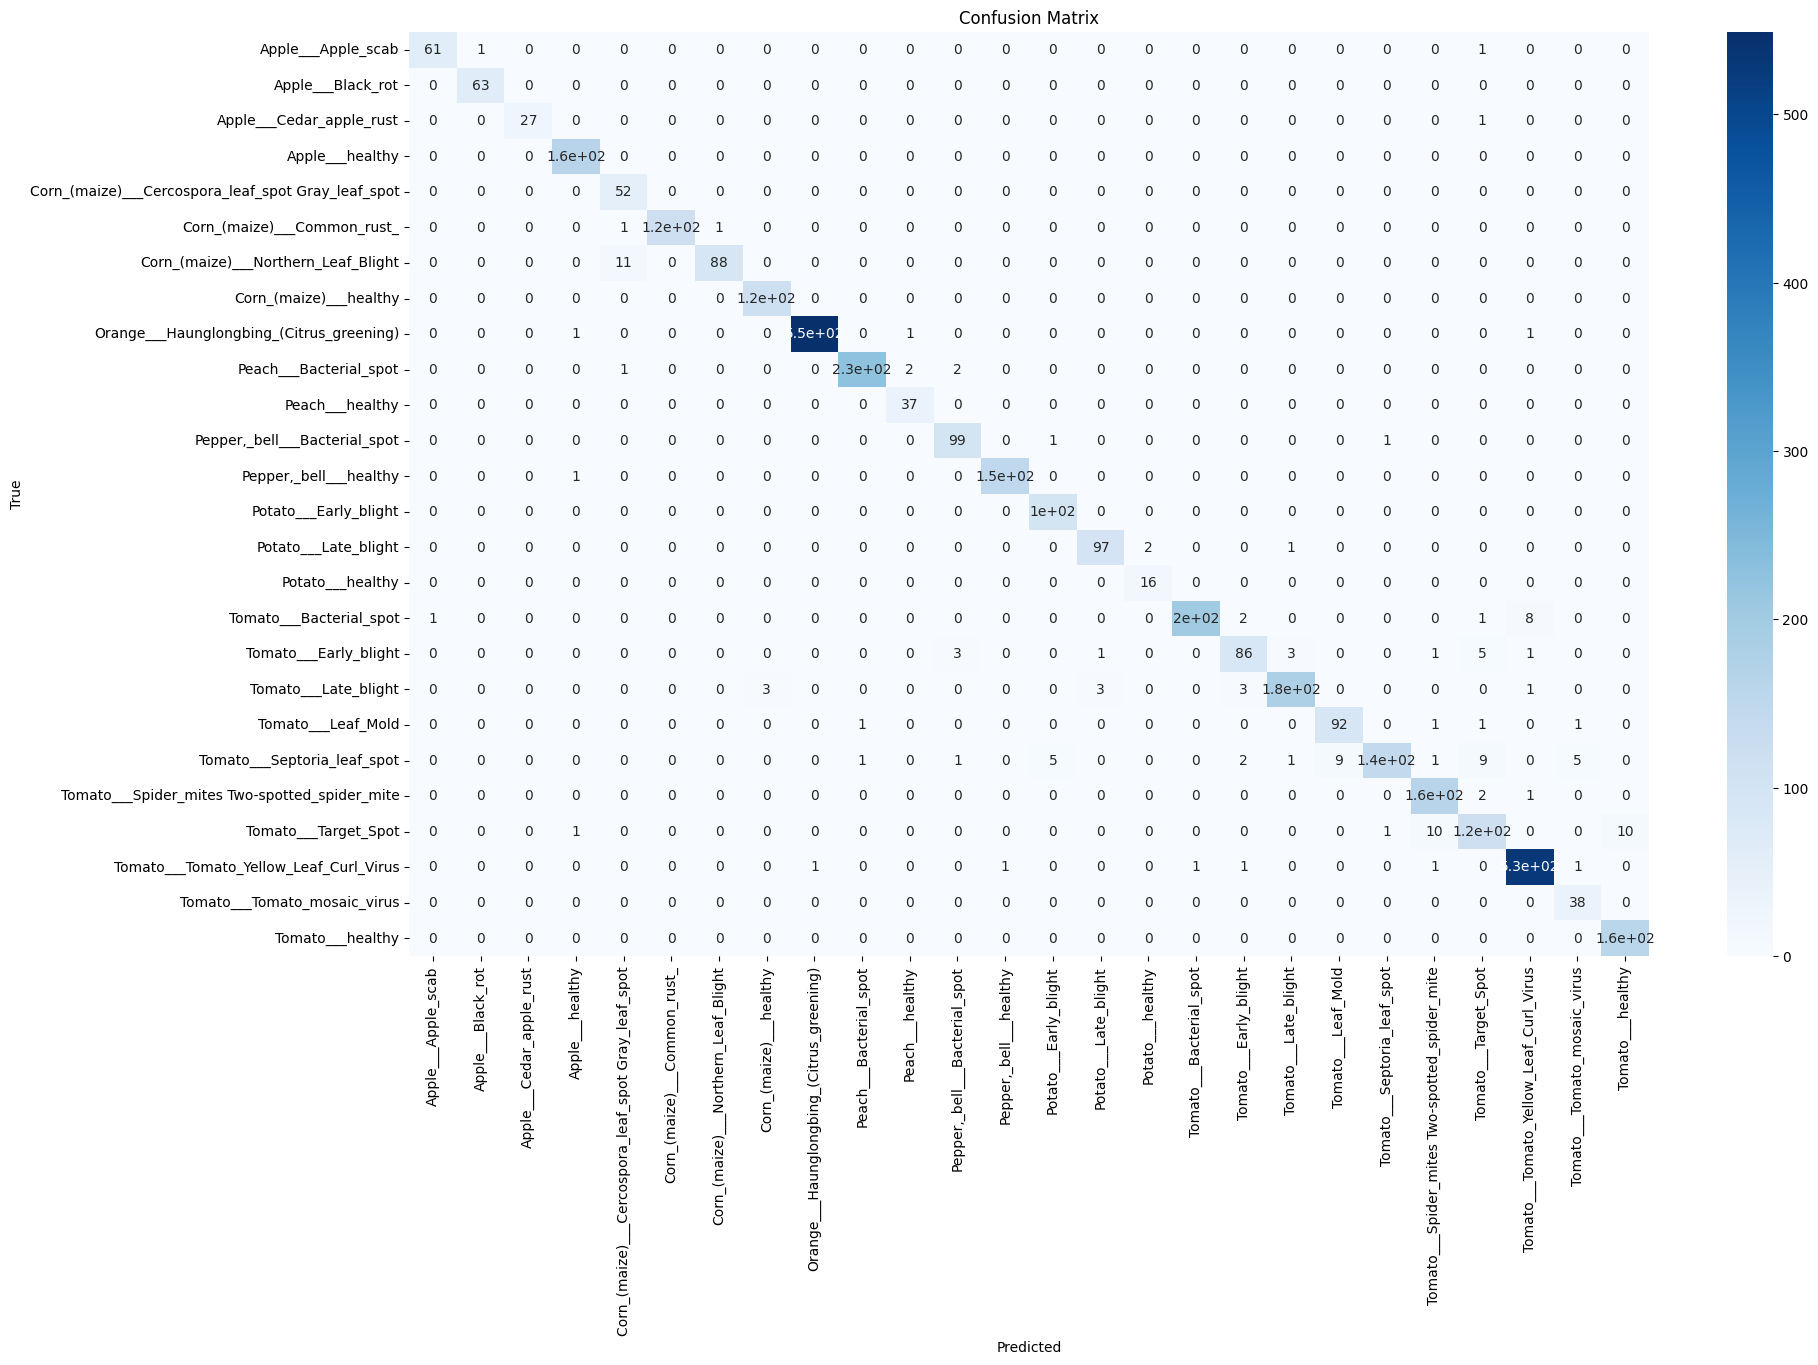

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True,  cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


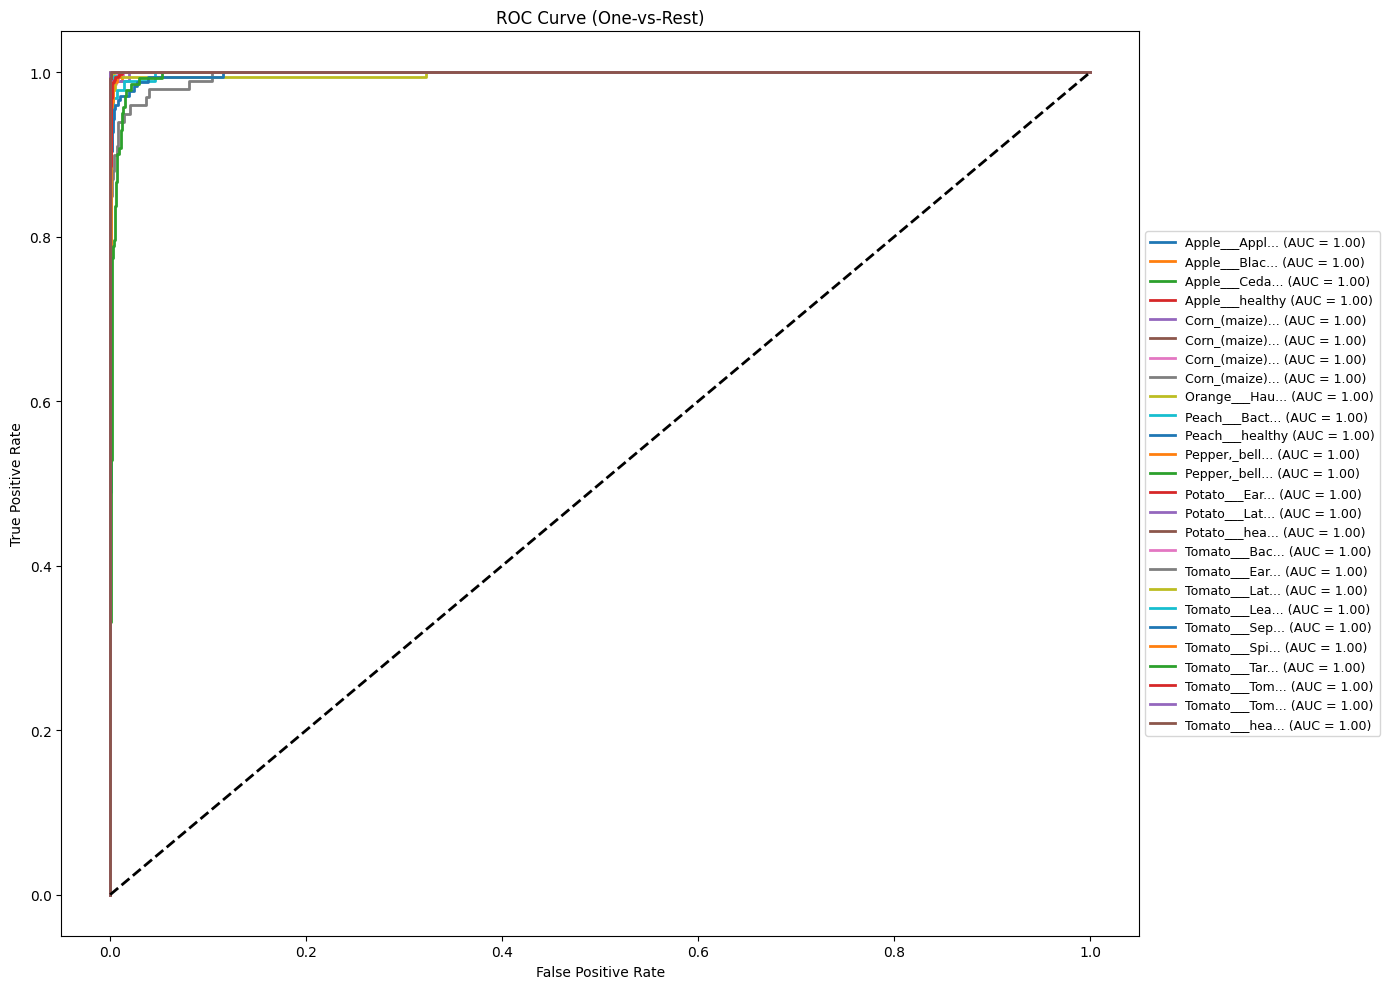

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
n_classes = y_true_bin.shape[1]

plt.figure(figsize=(14, 10))  

short_names = [name if len(name) <= 15 else name[:12]+"..." for name in class_names]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"{short_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.tight_layout()
plt.show()


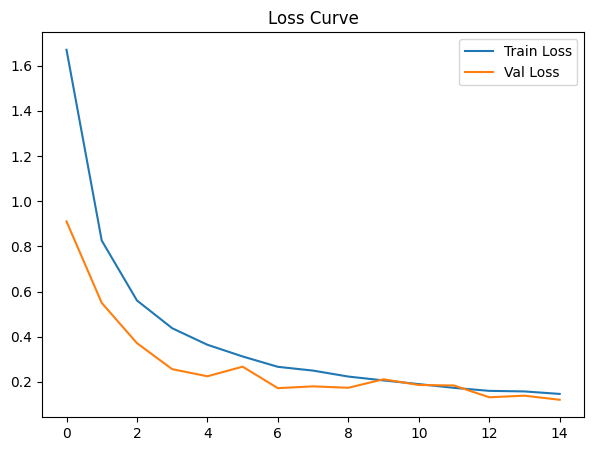

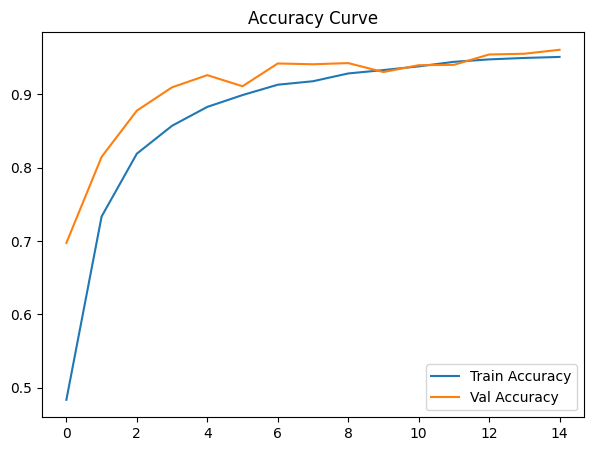

In [32]:
plt.figure(figsize=(7,5))
plt.plot(model_results["train_loss"], label="Train Loss")
plt.plot(model_results["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure(figsize=(7,5))
plt.plot(model_results["train_acc"], label="Train Accuracy")
plt.plot(model_results["val_acc"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()
